### Fast Style Transfer (Train)  
##### The program is only used for the graduate paper.
##### by Zian Gu

In [22]:
from __future__ import print_function
import evaluate
import functools
import tensorflow as tf
import time
import imageio
import numpy as np
import os
from PIL import Image
import src.vgg as vgg
import src.transform as transform

In [23]:
def save_img(out_path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    imageio.imwrite(out_path, img)

def scale_img(style_path, style_scale):
    scale = float(style_scale)
    o0, o1, o2 = imageio.imread(style_path, pilmode='RGB').shape
    scale = float(style_scale)
    new_shape = (int(o0 * scale), int(o1 * scale), o2)
    style_target = get_img(style_path, img_size=new_shape)
    return style_target

def get_img(src, img_size=False):
   img = imageio.imread(src, pilmode='RGB') # misc.imresize(, (256, 256, 3))
   if not (len(img.shape) == 3 and img.shape[2] == 3):
       img = np.dstack((img,img,img))
   if img_size != False:
       img = np.array(Image.fromarray(img).resize(img_size[:2]))
   return img

def exists(p, msg):
    assert os.path.exists(p), msg

def list_files(in_path):
    files = []
    for (dirpath, dirnames, filenames) in os.walk(in_path):
        files.extend(filenames)
        break

    return files

def _get_files(img_dir):
    files = list_files(img_dir)
    return [os.path.join(img_dir, x) for x in files]

#### optimize

In [24]:
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')
CONTENT_LAYER = 'relu4_2'
DEVICES = 'CUDA_VISIBLE_DEVICES'

In [25]:
# np arr, np arr
def optimize(content_targets, style_target, content_weight, style_weight,
             tv_weight, vgg_path, epochs=2, print_iterations=1000,
             batch_size=4, save_path='saver/fns.ckpt', slow=False,
             learning_rate=1e-3, debug=False):
    if slow:
        batch_size = 1
    mod = len(content_targets) % batch_size
    if mod > 0:
        print("Train set has been trimmed slightly..")
        content_targets = content_targets[:-mod]

    style_features = {}

    batch_shape = (batch_size, 256, 256, 3)
    style_shape = (1,) + style_target.shape
    print(style_shape)

    # precompute style features
    with tf.Graph().as_default(), tf.device('/cpu:0'), tf.compat.v1.Session() as sess:
        style_image = tf.compat.v1.placeholder(tf.float32, shape=style_shape, name='style_image')
        style_image_pre = vgg.preprocess(style_image)
        net = vgg.net(vgg_path, style_image_pre)
        style_pre = np.array([style_target])
        for layer in STYLE_LAYERS:
            features = net[layer].eval(feed_dict={style_image: style_pre})
            features = np.reshape(features, (-1, features.shape[3]))
            gram = np.matmul(features.T, features) / features.size
            style_features[layer] = gram

    with tf.Graph().as_default(), tf.compat.v1.Session() as sess:
        X_content = tf.compat.v1.placeholder(tf.float32, shape=batch_shape, name="X_content")
        X_pre = vgg.preprocess(X_content)

        # precompute content features
        content_features = {}
        content_net = vgg.net(vgg_path, X_pre)
        content_features[CONTENT_LAYER] = content_net[CONTENT_LAYER]

        if slow:
            preds = tf.Variable(
                tf.random.normal(X_content.get_shape()) * 0.256
            )
            preds_pre = preds
        else:
            preds = transform.net(X_content / 255.0)
            preds_pre = vgg.preprocess(preds)

        net = vgg.net(vgg_path, preds_pre)

        content_size = _tensor_size(content_features[CONTENT_LAYER]) * batch_size
        assert _tensor_size(content_features[CONTENT_LAYER]) == _tensor_size(net[CONTENT_LAYER])
        content_loss = content_weight * (2 * tf.nn.l2_loss(
            net[CONTENT_LAYER] - content_features[CONTENT_LAYER]) / content_size
                                         )

        style_losses = []
        for style_layer in STYLE_LAYERS:
            layer = net[style_layer]
            bs, height, width, filters = map(lambda i: i, layer.get_shape())
            size = height * width * filters
            feats = tf.reshape(layer, (bs, height * width, filters))
            feats_T = tf.transpose(a=feats, perm=[0, 2, 1])
            grams = tf.matmul(feats_T, feats) / size
            style_gram = style_features[style_layer]
            style_losses.append(2 * tf.nn.l2_loss(grams - style_gram) / style_gram.size)

        style_loss = style_weight * functools.reduce(tf.add, style_losses) / batch_size

        # total variation denoising
        tv_y_size = _tensor_size(preds[:, 1:, :, :])
        tv_x_size = _tensor_size(preds[:, :, 1:, :])
        y_tv = tf.nn.l2_loss(preds[:, 1:, :, :] - preds[:, :batch_shape[1] - 1, :, :])
        x_tv = tf.nn.l2_loss(preds[:, :, 1:, :] - preds[:, :, :batch_shape[2] - 1, :])
        tv_loss = tv_weight * 2 * (x_tv / tv_x_size + y_tv / tv_y_size) / batch_size

        loss = content_loss + style_loss + tv_loss

        # overall loss
        train_step = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)
        sess.run(tf.compat.v1.global_variables_initializer())
        import random
        uid = random.randint(1, 100)
        print("UID: %s" % uid)
        for epoch in range(epochs):
            num_examples = len(content_targets)
            iterations = 0
            while iterations * batch_size < num_examples:
                start_time = time.time()
                curr = iterations * batch_size
                step = curr + batch_size
                X_batch = np.zeros(batch_shape, dtype=np.float32)
                for j, img_p in enumerate(content_targets[curr:step]):
                    X_batch[j] = get_img(img_p, (256, 256, 3)).astype(np.float32)

                iterations += 1
                assert X_batch.shape[0] == batch_size

                feed_dict = {
                    X_content: X_batch
                }

                train_step.run(feed_dict=feed_dict)
                end_time = time.time()
                delta_time = end_time - start_time
                if debug:
                    print("UID: %s, batch time: %s" % (uid, delta_time))
                is_print_iter = int(iterations) % print_iterations == 0
                if slow:
                    is_print_iter = epoch % print_iterations == 0
                is_last = epoch == epochs - 1 and iterations * batch_size >= num_examples
                should_print = is_print_iter or is_last
                if should_print:
                    to_get = [style_loss, content_loss, tv_loss, loss, preds]
                    test_feed_dict = {
                        X_content: X_batch
                    }

                    tup = sess.run(to_get, feed_dict=test_feed_dict)
                    _style_loss, _content_loss, _tv_loss, _loss, _preds = tup
                    losses = (_style_loss, _content_loss, _tv_loss, _loss)
                    if slow:
                        _preds = vgg.unprocess(_preds)
                    else:
                        saver = tf.compat.v1.train.Saver()
                        res = saver.save(sess, save_path)
                    yield (_preds, losses, iterations, epoch)


def _tensor_size(tensor):
    from operator import mul
    return functools.reduce(mul, (d for d in tensor.get_shape()[1:]), 1)

In [26]:
# content_weight = 7.5e0
# style_weight = 1e2
# tv_weight = 2e2
# learning_rate = 1e-3
# epochs = 2
# batch_size = 4

content_weight = 1.2e3
style_weight = 1.5e3
tv_weight = 2e2 ###
learning_rate = 1e-3
epochs = 2
batch_size = 1 ###

In [27]:
style='data/s1.jpg'

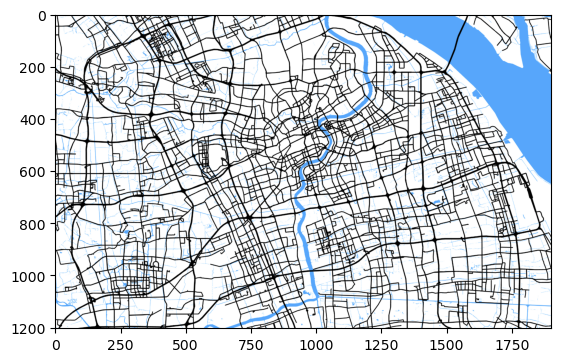

In [28]:
import matplotlib.pyplot as plt
im=plt.imread(style)
plt.imshow(im)

In [29]:
checkpoint_dir = 'checkpoints'
checkpoint_iterations = 100
vgg_path = 'data/imagenet-vgg-verydeep-19.mat'
train_path = 'data/plain'
DEVICE = '/gpu:0'
FRAC_GPU = 1
slow = False

In [30]:
from tensorflow.python.client import device_lib
# 列出所有的本地机器设备
local_device_protos = device_lib.list_local_devices()
local_device_protos

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13226335648306089018,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2232628020
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14611778864763351161
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [31]:
style_target = get_img(style)
content_targets = _get_files(train_path)


kwargs = {
    "slow": slow,
    "epochs": epochs, # Default: 2
    "print_iterations": checkpoint_iterations,
    "batch_size": batch_size,
#     "save_path": os.path.join(checkpoint_dir, 'cw-%s sw-%s tv-%s lr-%s e-%d.ckpt' % (content_weight,style_weight,tv_weight,learning_rate,epochs)),
    "save_path": os.path.join(checkpoint_dir, 'test.ckpt'),
    "learning_rate": learning_rate
}

args = [
    content_targets,
    style_target,
    content_weight,
    style_weight,
    tv_weight,
    vgg_path
]
start_time = time.time()
for preds, losses, i, epoch in optimize(*args, **kwargs):
    style_loss, content_loss, tv_loss, loss = losses

    print('Epoch %d, Iteration: %d, Loss: %s' % (epoch, i, loss))
    to_print = (style_loss, content_loss, tv_loss)
    print('style: %s, content:%s, tv: %s' % to_print)
end_time = time.time()
delta_time = end_time - start_time
ckpt_dir = checkpoint_dir
print("Training complete.Time: %s" % delta_time)
# print("Checkpoint file: cw-%s sw-%s tv-%s lr-%s e-%d.ckpt" % (content_weight,style_weight,tv_weight,learning_rate,epochs))
print('test.ckpt')

(1, 1203, 1902, 3)
UID: 29
Epoch 0, Iteration: 100, Loss: 5695582700.0
style: 4722331000.0, content:970034560.0, tv: 3216942.8
Epoch 0, Iteration: 200, Loss: 5359374000.0
style: 4139289900.0, content:1217407500.0, tv: 2676308.5
Epoch 0, Iteration: 300, Loss: 4893480400.0
style: 3786515200.0, content:1104379900.0, tv: 2585180.8
Epoch 0, Iteration: 400, Loss: 4580678700.0
style: 3453397200.0, content:1124769800.0, tv: 2511999.2
Epoch 1, Iteration: 100, Loss: 3868182800.0
style: 2810818000.0, content:1054835400.0, tv: 2529219.2
Epoch 1, Iteration: 200, Loss: 3469021700.0
style: 2175009300.0, content:1291751700.0, tv: 2260780.2
Epoch 1, Iteration: 300, Loss: 3069453800.0
style: 1867677200.0, content:1199634600.0, tv: 2142283.0
Epoch 1, Iteration: 400, Loss: 3203167200.0
style: 2131226500.0, content:1069814500.0, tv: 2126340.5
Epoch 1, Iteration: 444, Loss: 3098448400.0
style: 1671813500.0, content:1424727800.0, tv: 1907078.4
Training complete.Time: 231.7024073600769
test.ckpt
